In [172]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from tqdm import tqdm

import scipy.special

In [175]:
params = {'figure.titlesize': 'xx-large' }
pylab.rcParams.update(params)

In [118]:
# The actual prior variance
prior_var = 1

# Error bars in the last figure
percentile = 0.05

use_marcels_colorscheme = True

In [119]:
# This function estimates the expectation by evaluating the estimated variance 
# multiple times and returning the mean, using a given proposal prior

def gauss1d(x, mean, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(-0.5 * ((x - mean) ** 2) / var)

def sim_with_given_pp(prop_prior, N, alpha=0, nrounds=1000):
    npsamples = int(N * alpha)
    nppsamples = N - npsamples
    
    ppsamples = prop_prior.sample(size=(nrounds,nppsamples))
    psamples = np.random.normal(scale = np.sqrt(prior_var), size=(nrounds, npsamples))
    
    xlist = np.concatenate((ppsamples, psamples), axis=1)
    
    prior_evals = gauss1d(xlist, 0, prior_var)
    prop_prior_evals = prop_prior.eval(xlist)
    
    wlist = prior_evals / (alpha * prior_evals + (1 - alpha) * prop_prior_evals)

    mles = np.sum((xlist ** 2) * wlist, axis=1) / np.sum(wlist,axis=1)
    
    mean = np.mean(mles)
    percentiles = np.percentile(mles, [100 * percentile, 100 * (1 - percentile)])
    return mean, percentiles

In [160]:
# Proposal prior classes

class Gaussian:
    def __init__(self, var):
        self.var = var
        
    def sample(self, size):
        return np.sqrt(self.var) * np.random.normal(size=size)
    
    def eval(self, xlist):
        return gauss1d(xlist, 0, self.var)
    
def sim_with_gaussian_pp(prop_prior_var, N, alpha=0, nrounds=1000):
    return sim_with_given_pp(Gaussian(prop_prior_var), N, alpha=alpha, nrounds=nrounds)

class StudentsT:
    def __init__(self, var, dof):
        self.var = var
        self.dof = dof
        
    def sample(self, size):
        return np.sqrt(self.var) * np.random.standard_t(df=dof, size=size)
    
    def eval(self, xlist):
        lp = np.log(1 + (xlist ** 2) / (self.var * self.dof))
        lp *= -(self.dof + 1) / 2.0
        lp += np.log(scipy.special.gamma((self.dof + 1) / 2))
        lp -= scipy.special.gammaln(self.dof / 2) + \
            0.5 * np.log(self.dof * np.pi) + 0.5 * np.log(self.var)
            
        return np.exp(lp)
    
def sim_with_studentsT_wrapper(dof):
    def sim_with_studentsT_pp(prop_prior_var, N, alpha=0, nrounds=1000):
        return sim_with_given_pp(StudentsT(prop_prior_var,dof), N, alpha=alpha, nrounds=nrounds)
    
    return sim_with_studentsT_pp    

In [161]:
# This function estimates the expectation using the linear approximation and MC integration
# The linear approximation can give negative values, so this function is UNSTABLE!
# Not used at the moment, needs to be updated

def calc(prop_prior_var, N, alpha=0, nsamples=100000):
    xlist = np.random.normal(scale = np.sqrt(prior_var), size=nsamples)
    
    prior_evals = gauss1d(xlist, 0, prior_var)
    prop_prior_evals = gauss1d(xlist, 0, prop_prior_var)
    temp = prop_prior_evals / prior_evals
    wlist = 1 / (alpha + (1 - alpha) * temp)
    
    t0 = xlist ** 2
    t1 = - (xlist ** 2) * (wlist - 1) / N
    ylist = t0 + t1
    
    return np.mean(ylist)

In [191]:
def plot_estimates(pp_name, sim_lists):
    fig, axes = plt.subplots(len(alphas), sharex=True, sharey=True, figsize = (5, len(alphas) * 3))
    fig.suptitle("Proposal prior: {}".format(pp_name))

    for alpha, ax in zip(alphas, axes):
        for j in range(len(Nlist)):
            ylist = [ d[0] for d in sim_lists[alpha][Nlist[j]] ]         # Plot the average estimates
            color = None
            if use_marcels_colorscheme:
                color = [0,j / len(Nlist),0]
            ax.loglog(vlist, ylist, label="N = {}".format(Nlist[j]), color=color)

        ax.set_title("$\\alpha={}$".format(alpha))

        ax.set_ylabel("Average estimated variance")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    axes[-1].set_xlabel("Variance of proposal prior")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

In [203]:
def plot_error_bars(pp_name, sim_lists, vlist_idx = -1):
    fig, axes = plt.subplots(len(alphas), sharex=True, sharey=True, figsize = (5, len(alphas) * 3))
    fig.suptitle("Proposal prior: {}".format(pp_name))

    for alpha, ax in zip(alphas, axes):
        ylist = [ sim_lists[alpha][n][vlist_idx][0] for n in Nlist ]

        perclist = np.asarray([ sim_lists[alpha][n][vlist_idx][1] for n in Nlist ])
        errlist = (perclist.T)#- ylist)

        ax.errorbar(Nlist, ylist, yerr=errlist, fmt='o', capsize=4, color='black', ecolor='g')

        #ax.set_ylim((0.001, 0))
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log", nonposy='clip')

        ax.set_title("$\\alpha={}$".format(alpha))

        ax.set_ylabel("Estimated variance")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    axes[-1].set_xlabel("Sample size ($N$)")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

In [166]:
# List of proposal prior variances (x-axis)
vlist = prior_var * np.exp(-np.linspace(0, 5, 5))

# List of sample sizes to consider
Nlist = [ 30, 60, 100, 150, 300, 600, 1000, 1500, 3000, 6000, 10000 ]

# List of prior mixin values to consider
alphas = [ 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1 ]

doflist = [3, 10]
dists = { "Gaussian" : sim_with_gaussian_pp, 
          **{"Student's T (dof={})".format(dof) : sim_with_studentsT_wrapper(dof) for dof in doflist } }

# Run simulations (this takes a while)
sim_lists = { d : { alpha : { n: [ dists[d](i, n, alpha=alpha) for i in vlist] for n in Nlist } \
                    for alpha in tqdm(alphas) } \
              for d in dists }


100%|██████████| 5/5 [00:00<00:00, 42.54it/s]

100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

100%|██████████| 5/5 [00:00<00:00,  7.14it/s]

100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

100%|██████████| 5/5 [00:00<00:00, 42.88it/s]

100%|██████████| 5/5 [00:00<00:00, 10.57it/s]

100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

100%|██████████| 5/5 [00:00<00:00, 42.35it/s]

100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

100%|██████████| 5/5 [00:00<00:00, 41.63it/s]

100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

100%|███████

100%|██████████| 5/5 [00:00<00:00, 42.35it/s]

100%|██████████| 5/5 [00:00<00:00, 18.86it/s]

100%|██████████| 5/5 [00:00<00:00, 10.10it/s]

100%|██████████| 5/5 [00:00<00:00,  7.28it/s]

100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

100%|██████████| 5/5 [00:00<00:00, 48.30it/s]

100%|██████████| 5/5 [00:00<00:00, 10.35it/s]

100%|██████████| 5/5 [00:00<00:00,  6.27it/s]

100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

100%|██████████| 5/5 [00:08<00:00,  1.66s/it]

100%|██████████| 5/5 [00:00<00:00, 48.08it/s]

100%|██████████| 5/5 [00:00<00:00,  8.91it/s]

100%|██████████| 5/5 [00:00<00:00,  6.21it/s]

100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

100%|████████

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

100%|██████████| 5/5 [00:08<00:00,  1.63s/it]

100%|██████████| 5/5 [00:00<00:00, 47.54it/s]

100%|██████████| 5/5 [00:00<00:00, 10.22it/s]

100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

100%|██████████| 5/5 [00:00<00:00, 49.05it/s]

100%|██████████| 5/5 [00:00<00:00, 10.45it/s]

100%|██████████| 5/5 [00:00<00:00,  6.14it/s]

100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]

100%|██████████| 5/5 [00:00<00:00, 43.00it/s]

100%|██████████| 5/5 [00:00<00:00,  9.77it/s]

100%|██████████| 5/5 [00:00<00:00,  6.29it/s]

100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

100%|████████

100%|██████████| 5/5 [00:00<00:00,  6.18it/s]

100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

100%|██████████| 5/5 [00:00<00:00, 48.02it/s]

100%|██████████| 5/5 [00:00<00:00, 10.38it/s]

100%|██████████| 5/5 [00:00<00:00,  6.15it/s]

100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

100%|██████████| 5/5 [00:07<00:00,  1.60s/it]

100%|██████████| 5/5 [00:00<00:00, 49.11it/s]

100%|██████████| 5/5 [00:00<00:00, 10.42it/s]

100%|██████████| 5/5 [00:00<00:00,  6.24it/s]

100%|██████████| 5/5 [00:01<00:00,  4.31it/s]

100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

100%|██████████| 5/5 [00:00<00:00, 49.87it/s]

100%|██████████| 5/5 [00:00<00:00, 10.43it/s]

100%|████████

# Estimated variance vs. proposal prior variance

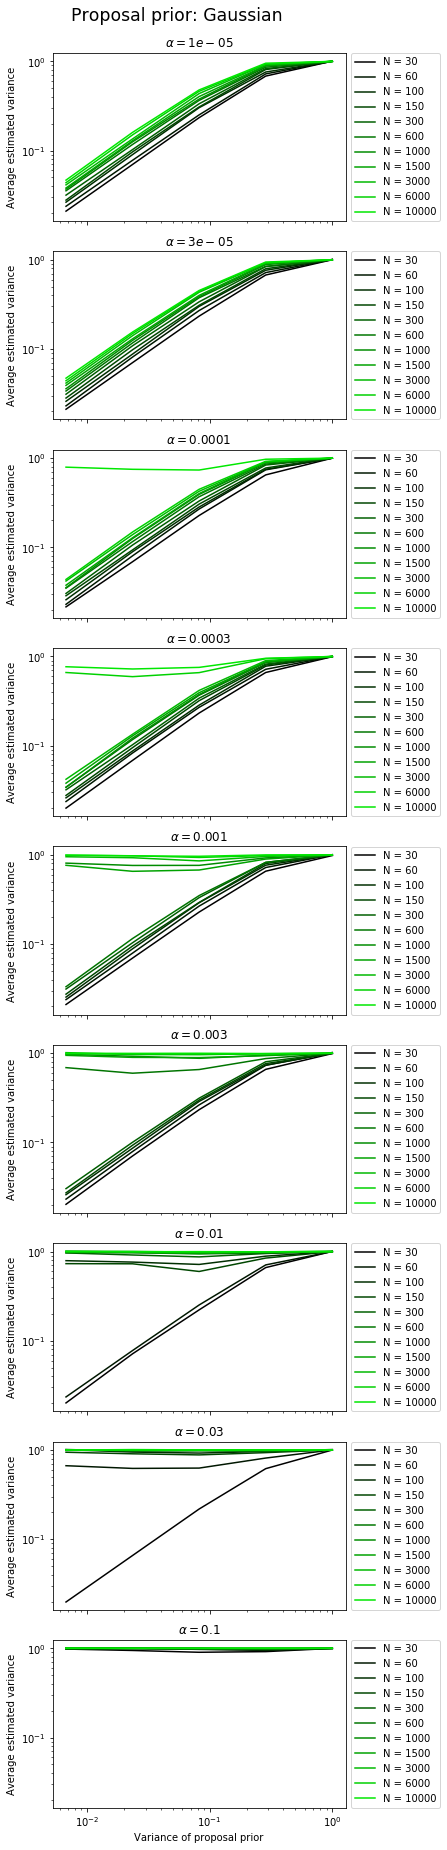

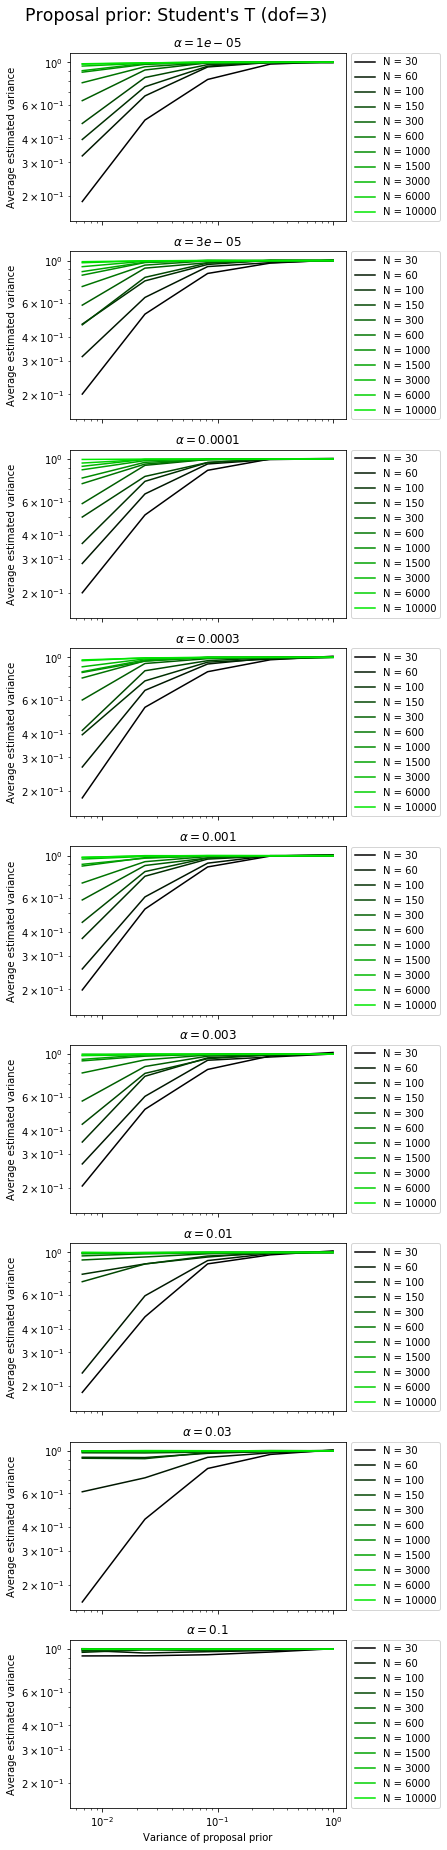

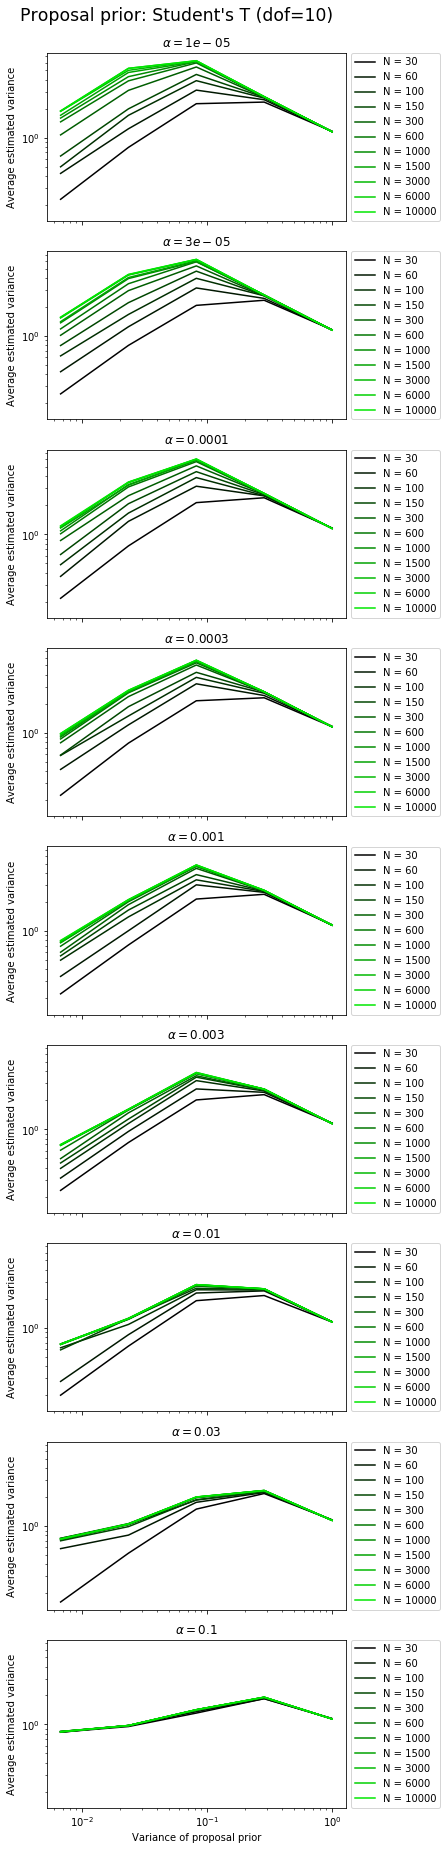

In [193]:
for d in dists:
    plot_estimates(d, sim_lists[d])

## Observations:

- In the Gaussian case there seems to be a sharp cutoff for each $N$: as soon as $\alpha N \lessapprox 1$, the variance estimate goes down sharply
- A Student's T pp with 3 dof is much more stable than a Gaussian pp; defensive importance sampling only starts to have a noticeable effect when the proposal prior has very low variance
- Student's T with 10 dof seems to overestimate the variance; defensive IS helps deal with the overestimation as well

## Variance of the estimators

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


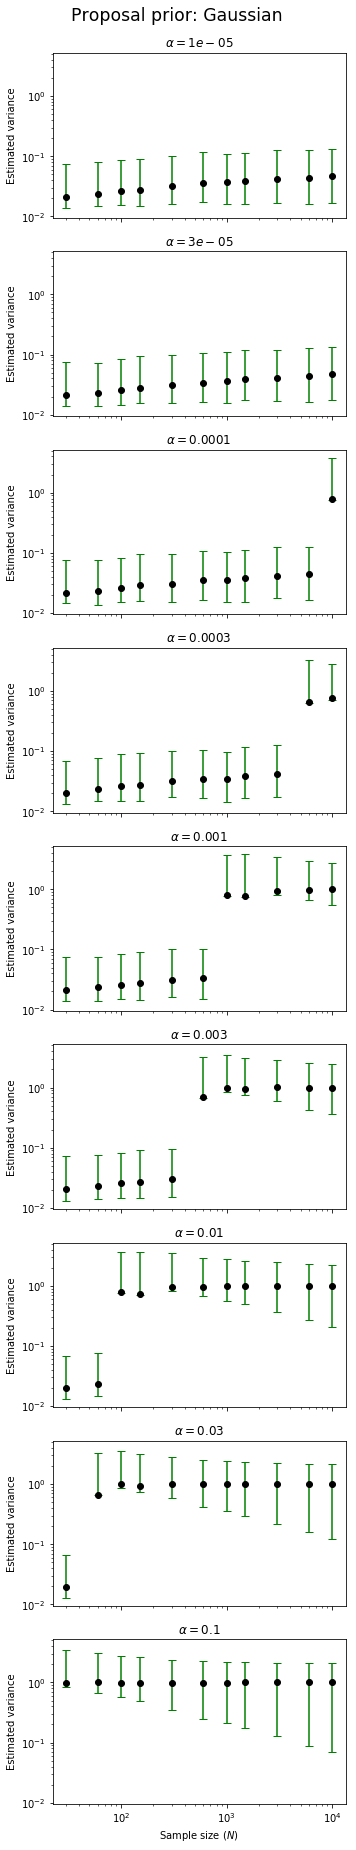

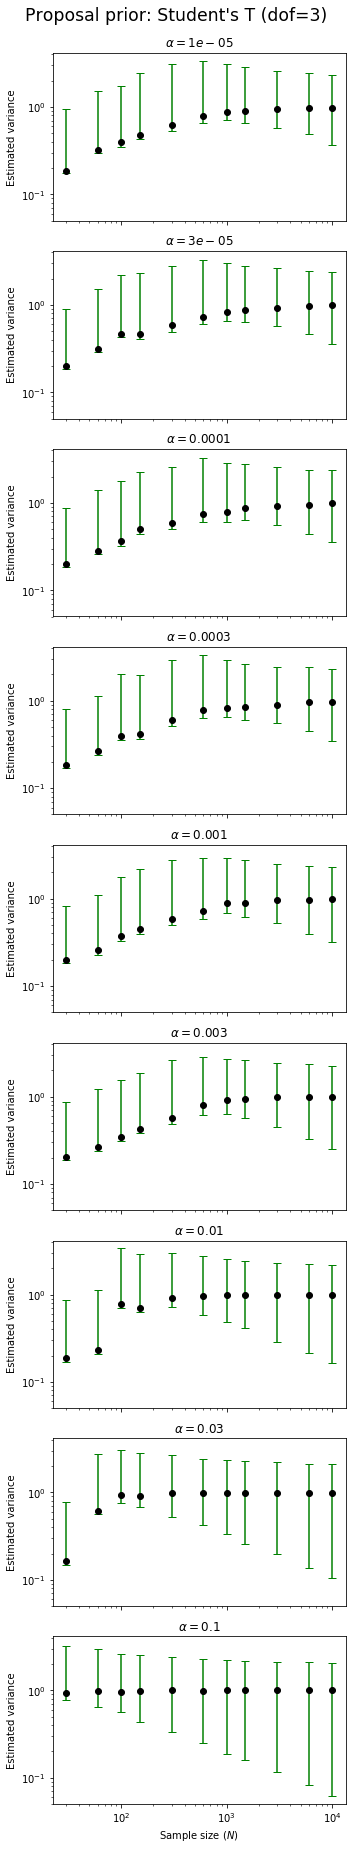

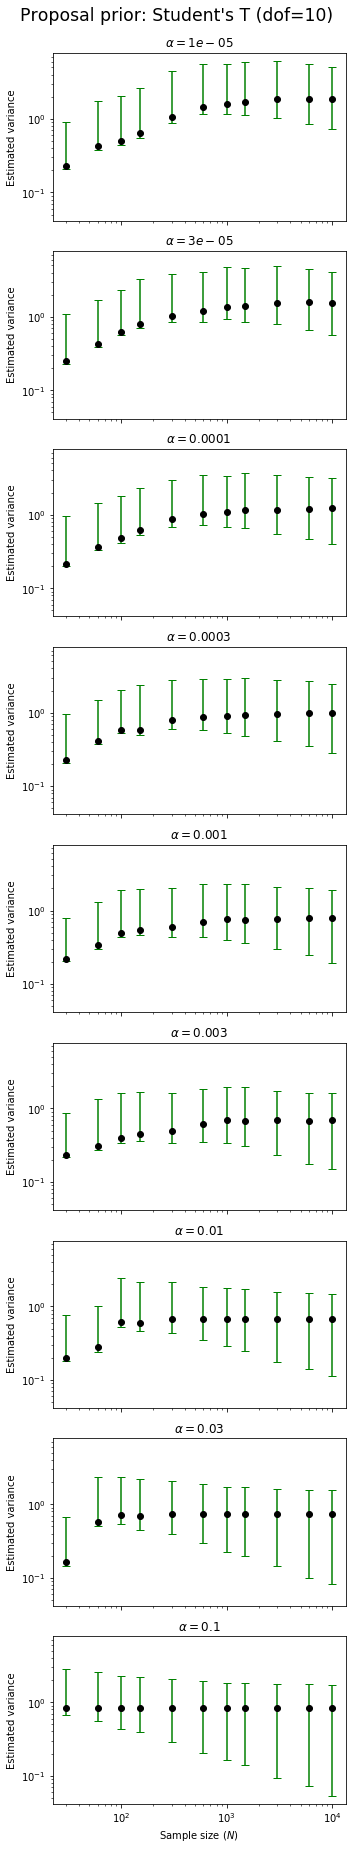

In [204]:
for d in dists:
    plot_error_bars(d, sim_lists[d])

## Observations:

- Adding defensive IS seems to increase the variance of the estimate (bias/variance tradeof), especially for large $N$
- For a Student's T proposal prior, the distributions seems less skewed with defensive IS, ie. the estimates seem to be more consistent